In [ ]:
COVID_EPOCHS = 20
PNEUMONIA_EPOCHS = 15
PNEUMOTHORAX_EPOCHS = 10
COVID_SEED = 123
PNEUMONIA_SEED = 123
PNEUMOTHORAX_SEED = 123

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Sequential
from tensorflow.keras.applications import ResNet50
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
import pathlib
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Dataset Parameters - CHANGE HERE
MODE = 'folder' # or 'file', if you choose a plain text file (see above).
#DATASET_PATH = '/content/gdrive/MyDrive/CSC522Project/CovidDataset/Dataset/' # the dataset file or root folder path.
DATASET_PATH = '/content/gdrive/MyDrive/CSC522Project/CovidDataset/StratifiedDataset/' # the dataset file or root folder path.

In [ ]:
# # # Begin Predict COVID-19 # # #

In [ ]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH+"Covid/",
    labels="inferred",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=COVID_SEED,
    validation_split=0.2, 
    subset="training",
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH+"Covid/",
    labels="inferred",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=COVID_SEED,
    validation_split=0.2, 
    subset="validation",
)

Found 7232 files belonging to 2 classes.
Using 5786 files for training.
Found 7232 files belonging to 2 classes.
Using 1446 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Normal']


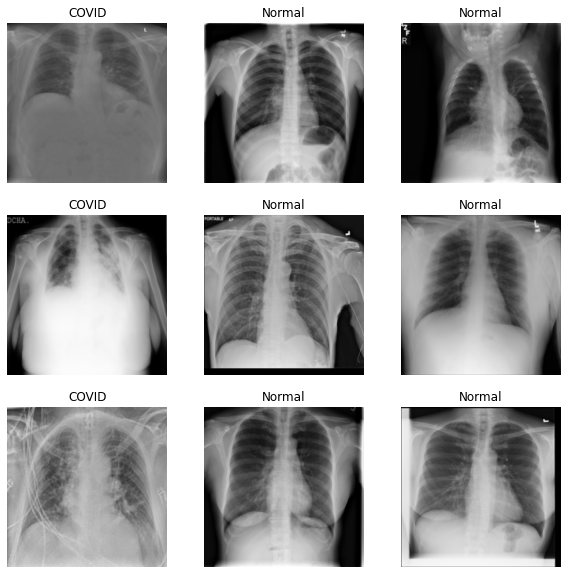

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_X = list()
train_y = list()
test_X = list()
test_y = list()

for image_batch_train, labels_batch_train in train_ds:
  for index in range(0, len(image_batch_train)):
    train_X.append(image_batch_train[index])
    train_y.append(labels_batch_train[index])

for image_batch, labels_batch in val_ds:
  for index in range(0, len(image_batch)):
    test_X.append(image_batch[index])
    test_y.append(labels_batch[index])

In [ ]:
# Conv_Base = ResNet50(weights=None, input_shape=(256, 256, 3), classes=2)
Conv_Base = ResNet50(weights=None, input_shape=(256, 256, 3), include_top=False)

for layer in Conv_Base.layers[:-8]:
    layer.trainable = False

layer = tf.keras.layers.Normalization(
    axis=None)

model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255))
model.add(Conv_Base)
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
opt = Adadelta(learning_rate=0.1)
model.compile(optimizer = opt, loss = 'BinaryCrossentropy', metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])
# try to add class weights to make it predict 0, since we currently only predict class label 1
class_weight = {0: 1.,
                1: 1.}


r=model.fit(x = train_ds, validation_data = val_ds, epochs = COVID_EPOCHS, class_weight=class_weight)

Epoch 1/20
181/181 [==============================] - 81s 400ms/step - loss: 0.7945 - accuracy: 0.6787 - precision: 0.7070 - recall: 0.6131 - val_loss: 0.7229 - val_accuracy: 0.5048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
181/181 [==============================] - 69s 377ms/step - loss: 0.4793 - accuracy: 0.7579 - precision: 0.8026 - recall: 0.6855 - val_loss: 0.7817 - val_accuracy: 0.5048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
181/181 [==============================] - 69s 378ms/step - loss: 0.4156 - accuracy: 0.7954 - precision: 0.8323 - recall: 0.7410 - val_loss: 0.7186 - val_accuracy: 0.5048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
181/181 [==============================] - 69s 377ms/step - loss: 0.3842 - accuracy: 0.8149 - precision: 0.8500 - recall: 0.7659 - val_loss: 0.6482 - val_accuracy: 0.6279 - val_precision: 0.9837 - val_recall: 0.2528
Epoch 5/20
181/181 [==============================] - 69s 377ms/step

In [ ]:
predictions = model.predict(val_ds)
predictions = np.ndarray.flatten(predictions)
predictions = np.where(predictions < 0.5, 0, 1) # Convert to 0 and 1.

np.set_printoptions(threshold=np.inf)
# print(predictions)

[1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1
 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0
 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0
 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0
 0 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1
 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1
 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1
 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1
 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1
 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 0 

In [ ]:
model.save('CovidNolan')
!zip -r /content/CovidNolan.zip /content/CovidNolan/

INFO:tensorflow:Assets written to: CovidNolan/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


  adding: content/CovidNolan/ (stored 0%)
  adding: content/CovidNolan/saved_model.pb (deflated 92%)
  adding: content/CovidNolan/assets/ (stored 0%)
  adding: content/CovidNolan/variables/ (stored 0%)
  adding: content/CovidNolan/variables/variables.index (deflated 82%)
  adding: content/CovidNolan/variables/variables.data-00000-of-00001 (deflated 44%)
  adding: content/CovidNolan/keras_metadata.pb (deflated 96%)


In [ ]:
# # # Begin Predict Pneumonia # # #

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH+"Pneumonia/",
    labels="inferred",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=COVID_SEED,
    validation_split=0.2, 
    subset="training",
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH+"Pneumonia/",
    labels="inferred",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=COVID_SEED,
    validation_split=0.2, 
    subset="validation",
)

Found 2870 files belonging to 2 classes.
Using 2296 files for training.
Found 2870 files belonging to 2 classes.
Using 574 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Normal', 'Pneumonia']


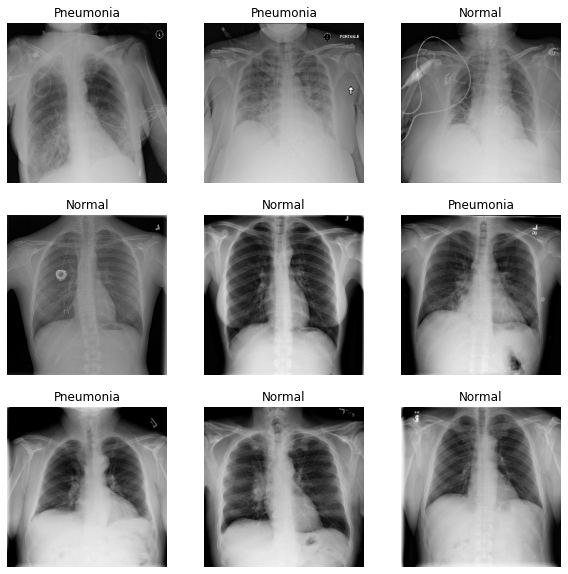

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
Conv_Base = ResNet50(weights=None, input_shape=(256, 256, 3), include_top=False)

for layer in Conv_Base.layers[:-8]:
    layer.trainable = False

model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255))
model.add(Conv_Base)
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
opt = Adadelta(learning_rate=0.25)
model.compile(optimizer = opt, loss = 'BinaryCrossentropy', metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])
# try to add class weights to make it predict 0, since we currently only predict class label 1
class_weight = {0: 1.,
                1: 1.}


r=model.fit(x = train_ds, validation_data = val_ds, epochs = PNEUMONIA_EPOCHS, class_weight=class_weight, shuffle=True)

Epoch 1/15
72/72 [==============================] - 108s 595ms/step - loss: 0.5909 - accuracy: 0.6703 - precision: 0.6311 - recall: 0.8197 - val_loss: 0.5803 - val_accuracy: 0.7038 - val_precision: 0.6795 - val_recall: 0.7869
Epoch 2/15
72/72 [==============================] - 45s 579ms/step - loss: 0.5802 - accuracy: 0.6755 - precision: 0.6321 - recall: 0.8397 - val_loss: 0.6689 - val_accuracy: 0.5714 - val_precision: 0.5425 - val_recall: 0.9863
Epoch 3/15
72/72 [==============================] - 44s 568ms/step - loss: 0.5875 - accuracy: 0.6677 - precision: 0.6243 - recall: 0.8423 - val_loss: 0.7451 - val_accuracy: 0.5801 - val_precision: 0.8676 - val_recall: 0.2027
Epoch 4/15
72/72 [==============================] - 44s 570ms/step - loss: 0.5790 - accuracy: 0.6725 - precision: 0.6316 - recall: 0.8275 - val_loss: 0.6067 - val_accuracy: 0.6760 - val_precision: 0.7512 - val_recall: 0.5395
Epoch 5/15
72/72 [==============================] - 45s 576ms/step - loss: 0.5931 - accuracy: 0.666

In [ ]:
predictions = model.predict(val_ds)
predictions = np.ndarray.flatten(predictions)
predictions = np.where(predictions < 0.5, 0, 1) # Convert to 0 and 1.

np.set_printoptions(threshold=np.inf)
# print(predictions)

[1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0
 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 

In [ ]:
# # # Begin Predict Pneumothorax # # #

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH+"Pneumothorax/",
    labels="inferred",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=PNEUMOTHORAX_SEED,
    validation_split=0.2, 
    subset="training",
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH+"Pneumothorax/",
    labels="inferred",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=PNEUMOTHORAX_SEED,
    validation_split=0.2, 
    subset="validation",
)

Found 6131 files belonging to 2 classes.
Using 4905 files for training.
Found 6131 files belonging to 2 classes.
Using 1226 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Normal', 'Pneumothorax']


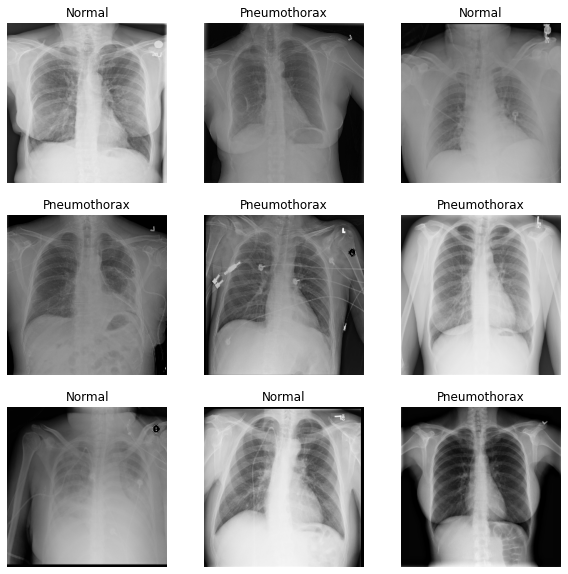

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
Conv_Base = ResNet50(weights=None, input_shape=(256, 256, 3), include_top=False)

for layer in Conv_Base.layers[:-8]:
    layer.trainable = False

model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255))
model.add(Conv_Base)
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
opt = Adadelta(learning_rate=0.25)
model.compile(optimizer = opt, loss = 'BinaryCrossentropy', metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])
# try to add class weights to make it predict 0, since we currently only predict class label 1
class_weight = {0: 1.,
                1: 1.}


r=model.fit(x = train_ds, validation_data = val_ds, epochs = PNEUMOTHORAX_EPOCHS, class_weight=class_weight, shuffle=True)

Epoch 1/10
154/154 [==============================] - 699s 4s/step - loss: 1.1708 - accuracy: 0.5297 - precision: 0.5225 - recall: 0.6204 - val_loss: 0.6925 - val_accuracy: 0.5595 - val_precision: 0.5387 - val_recall: 0.9456
Epoch 2/10
154/154 [==============================] - 94s 587ms/step - loss: 0.6799 - accuracy: 0.5664 - precision: 0.5458 - recall: 0.7575 - val_loss: 0.6906 - val_accuracy: 0.5098 - val_precision: 0.5098 - val_recall: 1.0000
Epoch 3/10
154/154 [==============================] - 95s 592ms/step - loss: 0.6757 - accuracy: 0.5527 - precision: 0.5322 - recall: 0.8248 - val_loss: 0.6862 - val_accuracy: 0.5701 - val_precision: 0.5456 - val_recall: 0.9376
Epoch 4/10
154/154 [==============================] - 96s 600ms/step - loss: 0.6676 - accuracy: 0.5847 - precision: 0.5657 - recall: 0.7062 - val_loss: 0.6746 - val_accuracy: 0.6191 - val_precision: 0.7409 - val_recall: 0.3888
Epoch 5/10
154/154 [==============================] - 95s 595ms/step - loss: 0.6598 - accuracy

In [ ]:
predictions = model.predict(val_ds)
predictions = np.ndarray.flatten(predictions)
predictions = np.where(predictions < 0.5, 0, 1) # Convert to 0 and 1.

np.set_printoptions(threshold=np.inf)
# print(predictions)